In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

def get_exp_ids_for_varying_k(corpus='amazon_grouped-tagged'):
    # curve when varying k
    query_dict = {'expansions__allow_overlap': 0,
                  'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                 'document_features_ev': 'AN+NN',
                 'document_features_tr': 'J+N+AN+NN',
                 'expansions__k__in': [1,3,5],
                 'labelled': 'amazon_grouped-tagged',
                 'expansions__neighbour_strategy': 'linear',
                 'expansions__noise': 0.0,
                 'expansions__use_random_neighbours': 0,
                 'expansions__use_similarity': 0,
                'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
                'expansions__vectors__algorithm': 'word2vec',
                 'expansions__vectors__dimensionality': 100,
                 'expansions__vectors__rep': 0,
                 'expansions__vectors__unlabelled': 'wiki',
                 'expansions__vectors__unlabelled_percentage': 100,
                 'expansions__vectors__use_ppmi': 0                  
}
    return Experiment.objects.filter(**query_dict)#.values_list('id', flat=True)

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


ids are [34, 35, 36, 37, 38, 39, 40, 41, 97, 107, 117, 127]
Composer has 6000 values
folds has 6000 values
k has 6000 values
Accuracy has 6000 values


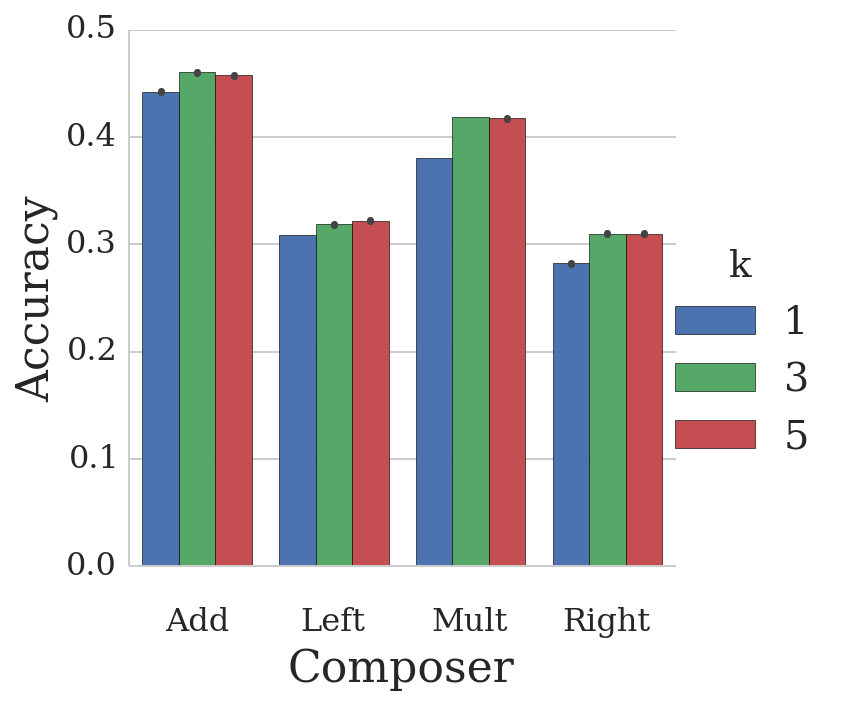

In [3]:
experiments = get_exp_ids_for_varying_k()
ids = [e.id for e in experiments if e.expansions.entries_of is None]
print('ids are', ids)

df = dataframe_from_exp_ids(ids, {'k':'expansions__k', 
                                  'Composer':'expansions__vectors__composer'})
grid = sns.factorplot(hue='k', y='Accuracy', data=df, x='Composer',
                      kind='bar');
plt.savefig('plot-w2v_effect-of-k.pdf', format='pdf', dpi=300)

In [98]:
def f1(x):
    return '%1.2f' % x

ddf = df.drop('folds', axis=1).groupby(['Composer', 'k']).agg([np.mean, np.std])
ddf.columns = ddf.columns.droplevel(0)#.reset_index()
ddf['Accuracy'] = ddf['mean'].map(f1) + "$\pm$" + ddf['std'].map(f1)
ddf = ddf.drop(['mean', 'std'], axis=1).reset_index()
print(ddf.pivot_table(values='Accuracy', index='k', 
                      columns='Composer', aggfunc=lambda x: x).to_latex(escape=False))
ddf = df.groupby(['Composer', 'k']).agg('mean').reset_index() # no need to drop unwanted columns
print(ddf.pivot_table(values='Accuracy', index='k', columns='Composer').to_latex(float_format=f1))

\begin{tabular}{lllll}
\toprule
Composer &            Add &           Left &           Mult &          Right \\
\midrule
k &                &                &                &                \\
1 &  0.44$\pm$0.00 &  0.31$\pm$0.01 &  0.38$\pm$0.00 &  0.28$\pm$0.01 \\
3 &  0.46$\pm$0.00 &  0.32$\pm$0.01 &  0.42$\pm$0.00 &  0.31$\pm$0.01 \\
5 &  0.46$\pm$0.00 &  0.32$\pm$0.01 &  0.42$\pm$0.00 &  0.31$\pm$0.01 \\
\bottomrule
\end{tabular}

